In [1]:
import msprime, tskit, time
import numpy as np
from IPython.display import SVG
import matplotlib.pyplot as plt

### The Truth
The following will be our final images, and data collection for how the `extend_edges` method compares to other methods/packages including `tsinfer` and `keep_unary`.

We first will generate a tree sequence which will serve as our 'ground truth'. 
Then using `simplify` we can then simplify this tree sequence using `TSkit` and then we extend the simplified tree sequence and compare.

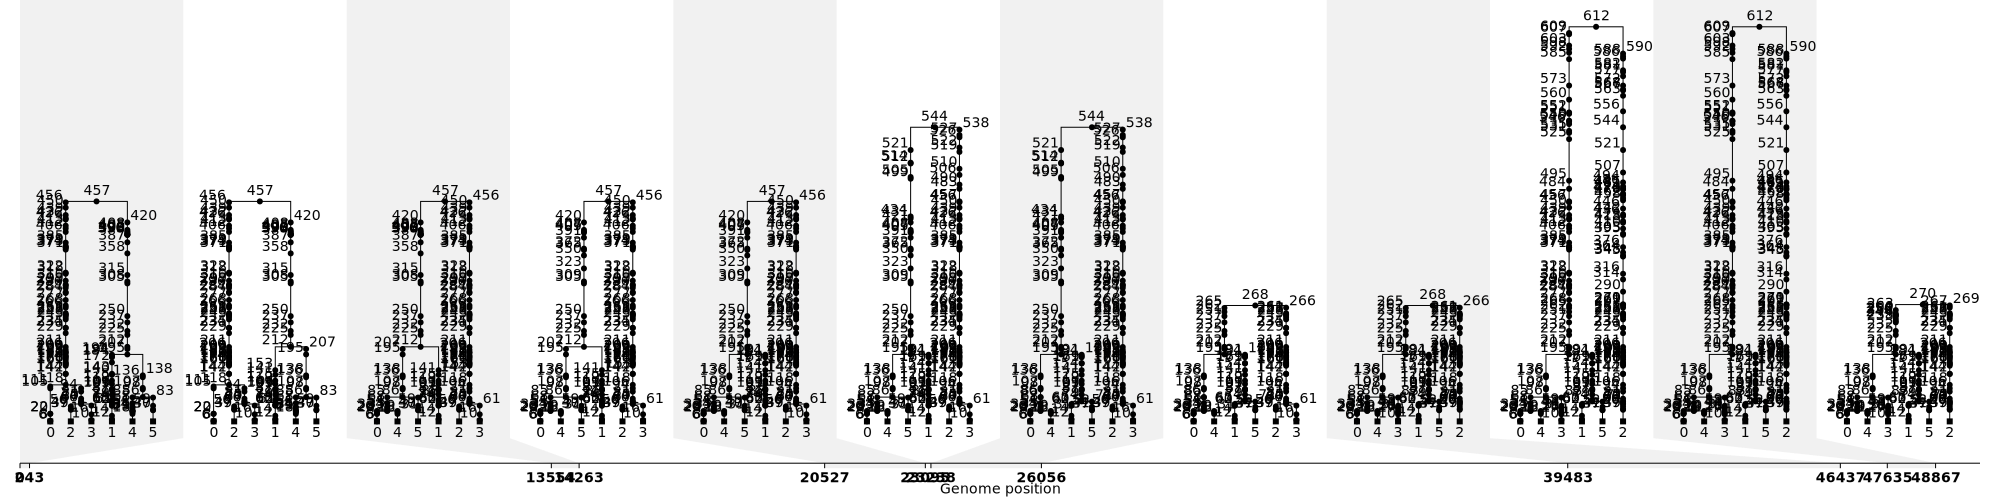

In [36]:
ts = msprime.sim_ancestry(3, population_size=1000, sequence_length=1e6, recombination_rate=1e-8,
                         record_full_arg=True)
SVG(ts.draw_svg(size=(2000, 500), x_lim=[0, 5e4]))

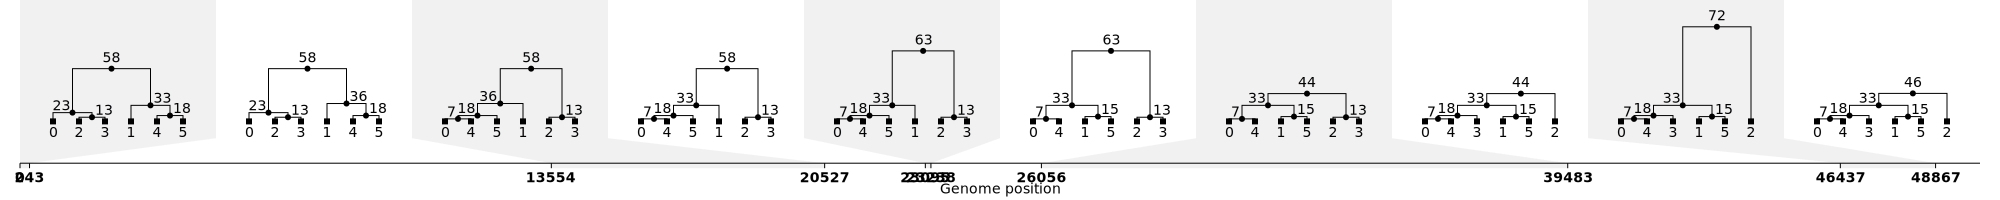

In [37]:
sts = ts.simplify()
# uts = ts.simplify(keep_unary=True)
SVG(sts.draw_svg(x_lim=[0, 5e4]))

Currently, we still have `extend_edges` output a bunch of print statements. We should fix that so it stops.

In [38]:
ets = sts.extend_edges()

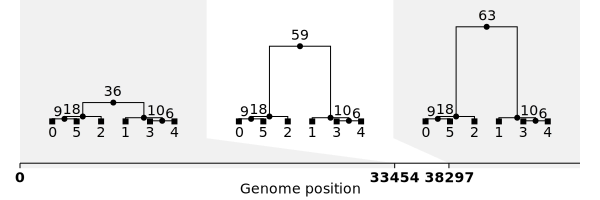

In [5]:
SVG(ets.draw_svg(x_lim=[0, 5e4]))

Note that `keep_unary_if_coalescence` is not a parameter anymore. 

There is now `keep_unary` which outputs the same tree sequence as the original (not helpful).

There is also `keep_unary_in_individuals` which has the same number of edges as simplified.

In [6]:
print("Number of edges:")
print(f" simplified: {sts.num_edges}")
# print(f" keep unary: {uts.num_edges}")
print(f"   extended: {ets.num_edges}")

Number of edges:
 simplified: 231
   extended: 185


### Lets see how many edges are reduced with 3 samples over 100 replicate tree sequences of genome length $10^6$

In [15]:
res = []
for ts in msprime.sim_ancestry(3, population_size=1000, sequence_length=1e6, recombination_rate=1e-8, random_seed=40,
                          record_full_arg=True, num_replicates=100):
    sts = ts.simplify()
    #new_sts = ts.simplify(keep_unary_if_coalescent=True)
    ets = sts.extend_edges()
    res.append((sts.num_edges, ets.num_edges))

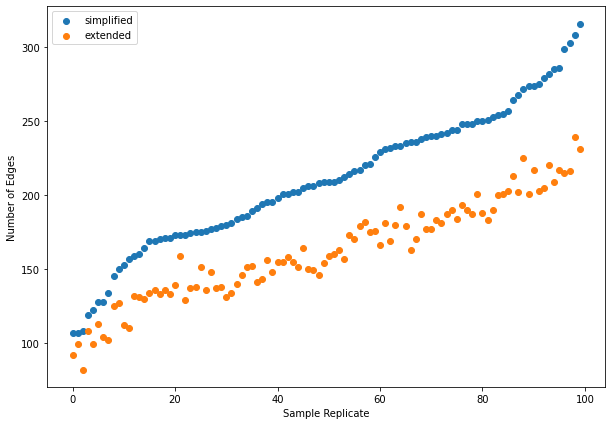

In [21]:
res = np.array(res)
x = np.argsort(np.argsort(res[:, 0]))

fig, ax = plt.subplots(figsize=(10,7))

ax.scatter(x, res[:, 0], label='simplified')
ax.scatter(x, res[:, 1], label='extended')
ax.set_xlabel('Sample Replicate')
ax.set_ylabel("Number of Edges")
ax.set_title('')
ax.legend();
plt.savefig('paper/simplified_vs_extended_100reps_SL1e6.png')


## Now lets extend our analysis to a sample size of 1000.

In [22]:
res = []
for ts in msprime.sim_ancestry(1000, population_size=1000, sequence_length=1e6, recombination_rate=1e-8, random_seed=40,
                          record_full_arg=True, num_replicates=100):
    sts = ts.simplify()
    #new_sts = ts.simplify(keep_unary_if_coalescent=True)
    ets = sts.extend_edges()
    res.append((sts.num_edges, ets.num_edges))

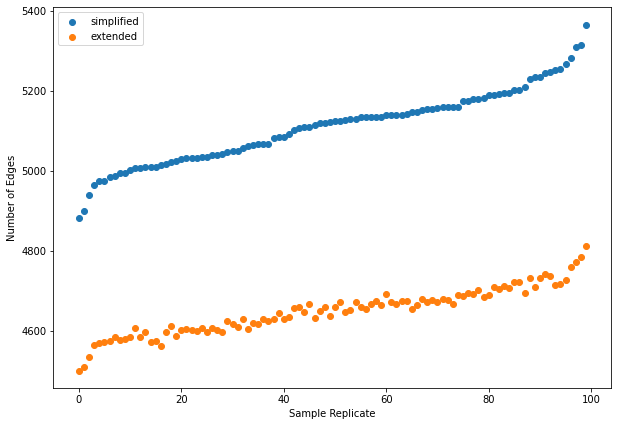

In [23]:
res = np.array(res)
x = np.argsort(np.argsort(res[:, 0]))

fig, ax = plt.subplots(figsize=(10,7))

ax.scatter(x, res[:, 0], label='simplified')
ax.scatter(x, res[:, 1], label='extended')
ax.set_xlabel('Sample Replicate')
ax.set_ylabel("Number of Edges")
ax.set_title('')
ax.legend();
plt.savefig('paper/simplified_vs_extended_1000sample_100reps_SL1e6.png')

### Now lets increase the genome length to $10^7$
We will decrease number of replicates to save time.

In [24]:
res = []
for ts in msprime.sim_ancestry(1000, population_size=1000, sequence_length=1e7, recombination_rate=1e-8, random_seed=40,
                          record_full_arg=True, num_replicates=50):
    sts = ts.simplify()
    #new_sts = ts.simplify(keep_unary_if_coalescent=True)
    ets = sts.extend_edges()
    print('extended!')
    res.append((sts.num_edges, ets.num_edges))

extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!


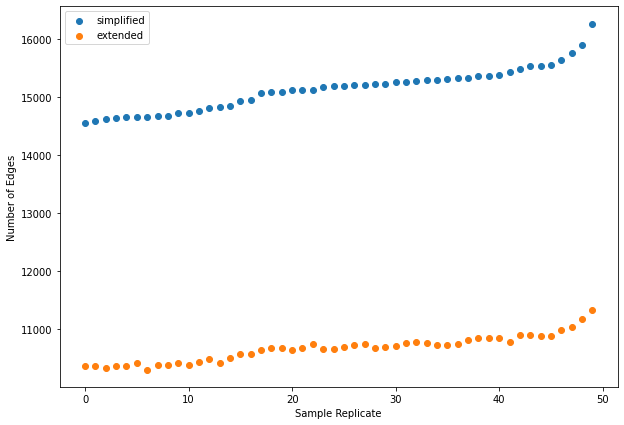

In [25]:
res = np.array(res)
x = np.argsort(np.argsort(res[:, 0]))

fig, ax = plt.subplots(figsize=(10,7))

ax.scatter(x, res[:, 0], label='simplified')
ax.scatter(x, res[:, 1], label='extended')
ax.set_xlabel('Sample Replicate')
ax.set_ylabel("Number of Edges")
ax.set_title('')
ax.legend();
plt.savefig('paper/simplified_vs_extended_1000sample_50reps_SL1e7.png')

### Compare ratio of edges to sequence length between simplified and extended tree sequences.

In [28]:
res = {}
for num_samples in [10, 100, 1000]:
    res[num_samples] = {}
    for L in [1e6, 3e6, 6e6, 9e6]:
        ts = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=L,
                                  recombination_rate=1e-8, record_full_arg=True)
        sts = ts.simplify()
        ext_sts = sts.extend_edges()
        res[num_samples][L] = (sts.num_edges, ext_sts.num_edges)

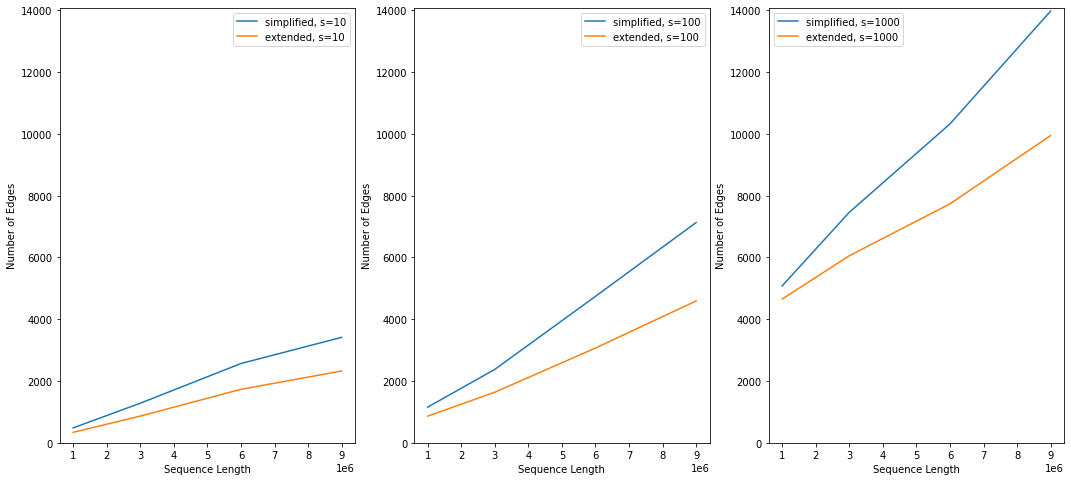

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

maxval = 0
for a in res.values():
    for b in a.values():
        maxval = max(maxval, max(b))

for ax, num_samples in zip(axes, res):
    Lvals = list(res[num_samples].keys())
    Lvals.sort()
    sim = [res[num_samples][L][0] for L in Lvals]
    ext = [res[num_samples][L][1] for L in Lvals]
    ax.plot(Lvals, sim, label=f"simplified, s={num_samples}")
    ax.plot(Lvals, ext, label=f"extended, s={num_samples}")
    ax.set_xlabel("Sequence Length")
    ax.set_ylabel("Number of Edges")
    ax.set_ylim(0, maxval+100)
    ax.legend();
    plt.savefig('paper/SL_vs_NumEdges.png')

### Edge Inference
We know look at proportion of edges which were correctly inserted into neighboring trees with `edge_extend`.

In [39]:
def get_span_stats(ts, ets):
    time_map = {}
    for n in ts.nodes():
        time_map[n.time] = n.id
    total_added_span = 0
    wrongly_added_span = 0
    for interval, t, et in ts.coiterate(ets):
        interval_length = interval[1] - interval[0]
        t_nodes = list(t.nodes())
        for n in et.nodes():
            if et.num_children(n) == 1:
                total_added_span += interval_length
            on = time_map[et.time(n)]
            if on not in t_nodes:
                assert et.num_children(n) == 1
                wrongly_added_span += interval_length
    return total_added_span, wrongly_added_span

In [40]:
total_added_span, wrongly_added_span = get_span_stats(ts, ets)
print(f"Out of a total of {total_added_span} added edge span, "
      f"we have wrongly added {wrongly_added_span} span, "
      f"a proportion of {wrongly_added_span / total_added_span}.")

Out of a total of 3037044.0 added edge span, we have wrongly added 2418.0 span, a proportion of 0.0007961689063444587.


# What's the sampling distribution?

In [61]:
reps = msprime.sim_ancestry(20, population_size=1000, sequence_length=1e6, recombination_rate=1e-8,
                           record_full_arg=True, num_replicates=100)
totals = []
wrongs = []
for ts in reps:
    ets = (ts.simplify()).extend_edges()
    a, b = get_span_stats(ts, ets)
    totals.append(a)
    wrongs.append(b)

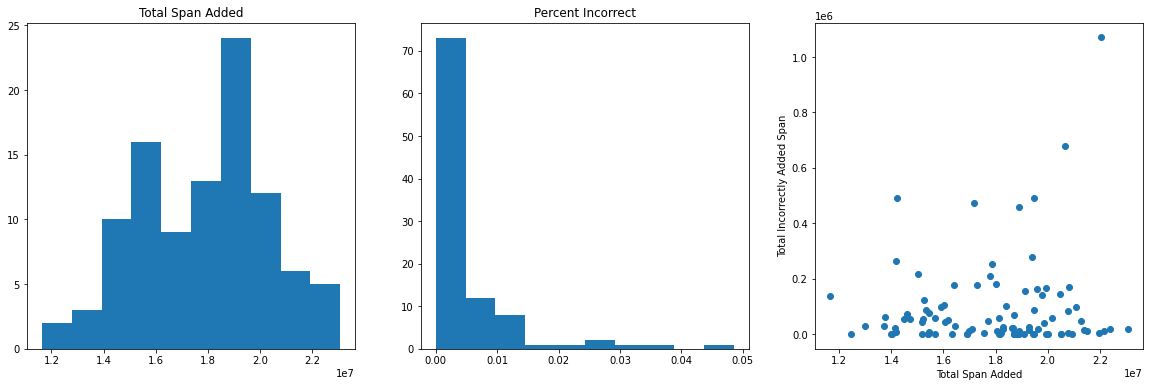

In [62]:
totals = np.array(totals)
wrongs = np.array(wrongs)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
ax1.hist(totals)
ax1.set_title("Total Span Added")
ax2.hist(wrongs/totals)
ax2.set_title("Percent Incorrect")
ax3.scatter(totals, wrongs)
ax3.set_xlabel("Total Span Added")
ax3.set_ylabel("Total Incorrectly Added Span")
plt.savefig('paper/sampling_distribution_recomb')

# Other ideas

- Make a plot with x-axis along the genome and y-axis time
with a line for each added edge
and color whether it was right or not.

# What's about gene conversion events?

Here's the same thing, but with gene conversion instead of recombination:

In [63]:
reps = msprime.sim_ancestry(20, population_size=1000, sequence_length=1e6, 
                            gene_conversion_rate=1e-8, gene_conversion_tract_length=1000,
                            record_full_arg=True, num_replicates=100)
totals = []
wrongs = []
for ts in reps:
    ets = (ts.simplify()).extend_edges()
    a, b = get_span_stats(ts, ets)
    totals.append(a)
    wrongs.append(b)

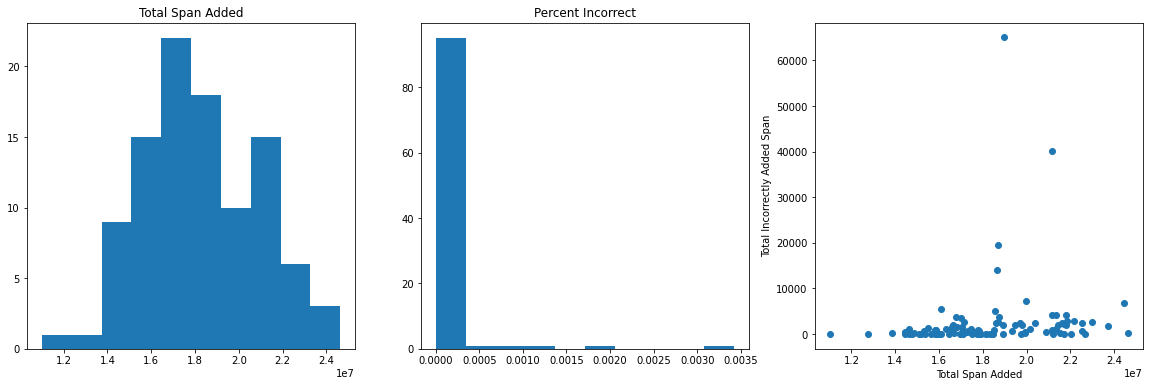

In [64]:
totals = np.array(totals)
wrongs = np.array(wrongs)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
ax1.hist(totals)
ax1.set_title("Total Span Added")
ax2.hist(wrongs/totals)
ax2.set_title("Percent Incorrect")
ax3.scatter(totals, wrongs)
ax3.set_xlabel("Total Span Added")
ax3.set_ylabel("Total Incorrectly Added Span");
plt.savefig('paper/sampling_distribution_geneconversion')